# One-Way ANOVA Test

> Use Case:
- ANOVA is used to determine whether there are statistically significant differences in the means of multiple variations (A, B, C, D) in an A/B/C/D test scenario.

> Assumptions:
- The data within each variation is approximately normally distributed.
- Homogeneity of variances, meaning that the variance within each group is roughly equal.
- Independence of observations, assuming that the observations within each group are independent of each other.
> Example Scenario:
- Suppose a website is testing four different versions (A, B, C, D) of a landing page to see which one results in the highest average time spent on the site. 
- Each variation is exposed to a different group of users.

> Null Hypothesis (H0):
- There is no significant difference in the average time spent on the site among variations A, B, C, and D.

> Alternative Hypothesis (H1):
- At least one of the variations (A, B, C, or D) has a different effect on the average time spent on the site compared to the others.

> Post-Hoc Tests:
- If ANOVA indicates that there are significant differences among the groups, post-hoc tests (e.g., Tukey's HSD, Bonferroni) can be conducted to identify which specific groups differ from each other.

In [20]:
import warnings

warnings.filterwarnings("ignore")

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from statsmodels.stats.power import FTestAnovaPower
from statsmodels.stats.multicomp import pairwise_tukeyhsd


# !pip install scipy==1.12.0
from scipy.stats import f_oneway, shapiro, levene, probplot, tukey_hsd

# !pip install pingouin==0.5.5
import pingouin as pg

In [22]:
# Set random seed for reproducibility
np.random.seed(42)

In [23]:
# set seaborn style
sns.set(style="white", palette="mako")

# colors
color = 'orange'

# remove some borders    
plt.rcParams['axes.axisbelow'] = True
plt.rcParams['axes.spines.left'] = False
plt.rcParams['axes.spines.bottom'] = True
plt.rcParams['axes.spines.top'] = False
plt.rcParams['axes.spines.right'] = False

### Power Analysis

In [24]:
# Set parameters for power analysis
alpha = 0.05  # Significance level
power = 0.8  # Desired power

# Number of groups (treatments) in the ANOVA
num_groups = 3

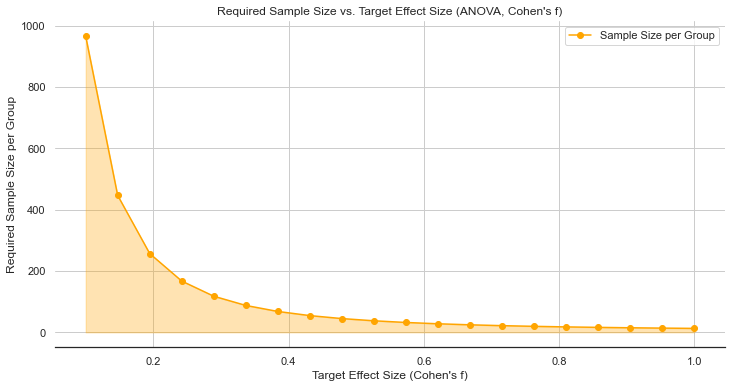

In [25]:
# Define a range of effect sizes to explore
effect_sizes = np.linspace(0.1, 1.0, 20) # From small to large effect sizes

# Initialize an empty list to store the calculated sample sizes
sample_sizes = []

# Iterate over the effect sizes and calculate the required sample size for each
for effect in effect_sizes:
    # Perform power analysis to calculate sample size
    analysis = FTestAnovaPower()
    n = analysis.solve_power(effect_size=effect, alpha=alpha, nobs=None, k_groups=num_groups, power=power)
    if n is not None:
        sample_sizes.append(n)
    else:
        sample_sizes.append(np.nan) # Append NaN if calculation fails

# Plot the effect sizes against the required sample sizes
plt.figure(figsize=(12, 6))
plt.plot(effect_sizes, sample_sizes, marker='o', linestyle='-', color=color, label='Sample Size per Group')
plt.fill_between(effect_sizes, sample_sizes, color=color, alpha=0.3)
plt.title('Required Sample Size vs. Target Effect Size (ANOVA, Cohen\'s f)')
plt.xlabel('Target Effect Size (Cohen\'s f)')
plt.ylabel('Required Sample Size per Group')
plt.grid(True)
plt.legend()
plt.show()

In [26]:
# Let's say we anticipate a small effect size (Cohen's f = 0.1)
effect = 0.1

# Perform power analysis to calculate sample size
analysis = FTestAnovaPower()
sample_size_per_group = int(round(analysis.solve_power(effect_size=effect, alpha=alpha, nobs=None, k_groups=num_groups, power=power), 0))

print(f"Sample size needed per group: {sample_size_per_group}")

Sample size needed per group: 966


### Synthetic Data

In [27]:
# Generate synthetic data for ANOVA
variation_A = np.random.normal(loc=50, scale=10, size=sample_size_per_group)
variation_B = np.random.normal(loc=55, scale=10, size=sample_size_per_group)
variation_C = np.random.normal(loc=60, scale=10, size=sample_size_per_group)
variation_D = np.random.normal(loc=65, scale=10, size=sample_size_per_group)

# Create pandas DataFrame
anova_data = pd.DataFrame({'variation_A': variation_A, 'variation_B': variation_B, 'variation_C':variation_C , 'variation_D':variation_D})
anova_data


,variation_A,variation_B,variation_C,variation_D
0,54.967142,48.236077,55.346895,62.125525
1,48.617357,73.009404,58.940516,67.873289
2,56.476885,54.598420,86.443433,64.544878
3,65.230299,40.692249,44.970297,60.757637
4,47.658466,56.281044,62.537397,59.301671
...,...,...,...,...
961,63.291525,52.139958,62.153965,63.046096
962,51.965212,66.009596,65.082686,60.480506
963,57.090038,74.583475,99.262377,57.106615
964,49.102643,42.704504,39.158871,64.929550


### Assumptions (SciPy)

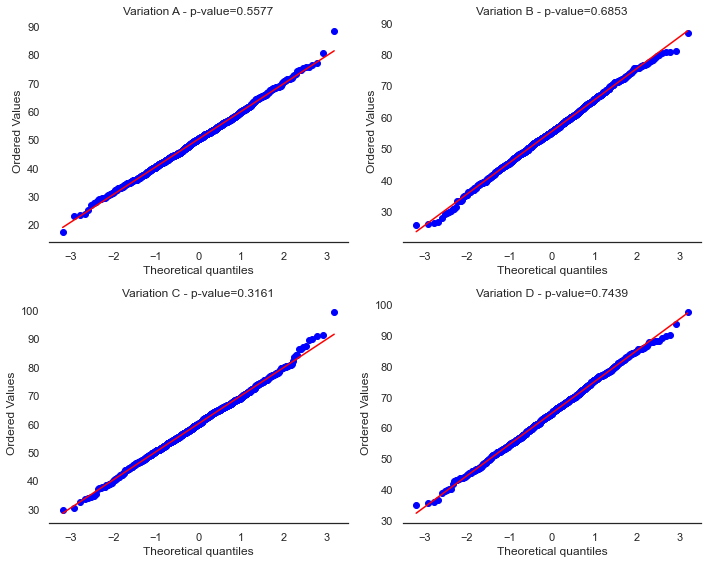

In [28]:
# Check for normality using Shapiro-Wilk test
_, p_value_A = shapiro(variation_A)
_, p_value_B = shapiro(variation_B)
_, p_value_C = shapiro(variation_C)
_, p_value_D = shapiro(variation_D)

# Visualize normality using Q-Q plots
fig, axes = plt.subplots(2, 2, figsize=(10, 8))
axes = axes.flatten()

for i, (variation, p_value) in enumerate(zip([variation_A, variation_B, variation_C, variation_D],
                                              [p_value_A, p_value_B, p_value_C, p_value_D])):
    probplot(variation, dist='norm', plot=axes[i])
    axes[i].set_title(f'Variation {chr(65 + i)} - p-value={p_value:.4f}')

plt.tight_layout()
plt.show()

Levene's Test (Homogeneity of Variances): p-value=0.4927
There is no strong evidence to reject the hypothesis that the variances are equal.


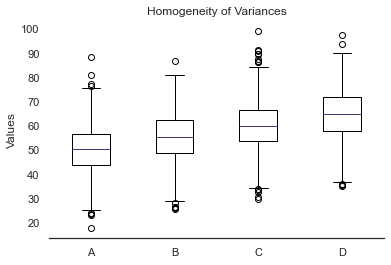

In [29]:
# Check for homogeneity of variances using Levene's test
_, p_value_levene = levene(variation_A, variation_B, variation_C, variation_D)
# Print the results
print(f"Levene's Test (Homogeneity of Variances): p-value={p_value_levene:.4f}")
if p_value_levene < 0.05:
    print("There are significant differences in variances between at least two groups.")
else:
    print("There is no strong evidence to reject the hypothesis that the variances are equal.")


# Visualize homogeneity of variances
plt.boxplot([variation_A, variation_B, variation_C, variation_D], labels=['A', 'B', 'C', 'D'])
plt.title('Homogeneity of Variances')
plt.ylabel('Values')
plt.show()

### One-Way ANOVA (SciPy)

In [30]:
# Perform one-way ANOVA
statistic, p_value = f_oneway(variation_A, variation_B, variation_C, variation_D)

# Check the p-value
if p_value < 0.05:
    print("ANOVA indicates significant differences among at least one of the variations ")
else:
    print("No significant differences among variations.")

ANOVA indicates significant differences among at least one of the variations 


### Post-Hoc (SciPy)

In [31]:
# Combine data into separate lists for scipy.stats.tukey_hsd
data = [variation_A, variation_B, variation_C, variation_D]

# Perform Tukey's HSD using scipy.stats
tukey_result = tukey_hsd(*data)

print("\nTukey's HSD Post-Hoc Test Results (SciPy):")
print(tukey_result)



Tukey's HSD Post-Hoc Test Results (SciPy):
Tukey's HSD Pairwise Group Comparisons (95.0% Confidence Interval)
Comparison  Statistic  p-value  Lower CI  Upper CI
 (0 - 1)     -5.273     0.000    -6.437    -4.110
 (0 - 2)     -9.855     0.000   -11.019    -8.692
 (0 - 3)    -14.539     0.000   -15.702   -13.375
 (1 - 0)      5.273     0.000     4.110     6.437
 (1 - 2)     -4.582     0.000    -5.746    -3.419
 (1 - 3)     -9.265     0.000   -10.429    -8.102
 (2 - 0)      9.855     0.000     8.692    11.019
 (2 - 1)      4.582     0.000     3.419     5.746
 (2 - 3)     -4.683     0.000    -5.847    -3.520
 (3 - 0)     14.539     0.000    13.375    15.702
 (3 - 1)      9.265     0.000     8.102    10.429
 (3 - 2)      4.683     0.000     3.520     5.847



### Assumptions (pingouin)

In [32]:
# Convert the DataFrame to the long format required by pingouin
anova_data_long = pd.melt(anova_data, var_name='group', value_name='value')

Shapiro-Wilk Normality Tests (Pingouin):


,,W,pval,normal
group,,,,
variation_A,variation_A,0.998457,0.557729,True
variation_B,variation_B,0.998654,0.685314,True
variation_C,variation_C,0.998014,0.316142,True
variation_D,variation_D,0.998745,0.743943,True


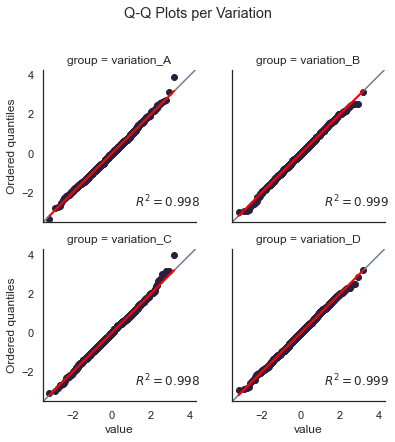

In [33]:
# Check for Normality using pingouin's shapiro
normality_results = anova_data_long.groupby('group')['value'].apply(pg.normality)
print("Shapiro-Wilk Normality Tests (Pingouin):")
display(normality_results)

# Visualize Normality using Q-Q plots per group
g = sns.FacetGrid(anova_data_long, col="group", col_wrap=2)
g.map(pg.qqplot, "value", dist='norm', confidence=True)
plt.suptitle('Q-Q Plots per Variation', y=1.02)
plt.tight_layout()
plt.show()

Levene's Test for Homoscedasticity (Pingouin):


,W,pval,equal_var
levene,0.801845,0.492687,True


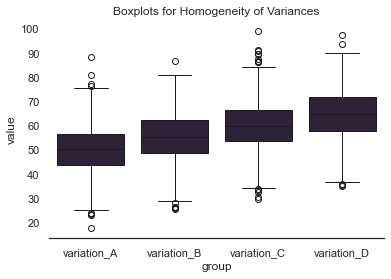

In [34]:
# Check for Homogeneity of Variances using pingouin's homoscedasticity (Levene)
homoscedasticity_levene = pg.homoscedasticity(data=anova_data_long, dv='value', group='group', method='levene')
print("Levene's Test for Homoscedasticity (Pingouin):")
display(homoscedasticity_levene)

# Visualize Homogeneity of Variances (Boxplots)
sns.boxplot(x='group', y='value', data=anova_data_long)
plt.title('Boxplots for Homogeneity of Variances')
plt.show()

### One-Way ANOVA (pingouin)

In [ ]:
# Perform one-way ANOVA using pingouin
anova_table = pg.anova(data=anova_data_long, dv='value', between='group')
print("ANOVA Results (Pingouin):")
display(anova_table)

# Check the p-value
if anova_table.loc[0,'p-unc'] < 0.05:
    print("ANOVA indicates significant differences among at least one of the variations ")
else:
    print("No significant differences among variations.")

ANOVA Results (Pingouin):


,Source,ddof1,ddof2,F,p-unc,np2
0,group,3,3860,378.290714,2.164534e-215,0.227207


ANOVA indicates significant differences among at least one of the variations 


### Post-Hoc (statsmodels)

In [ ]:
tukey_result = pairwise_tukeyhsd(anova_data_long['value'], anova_data_long['group'], alpha=0.05)

# Convert the results to a pandas DataFrame for easier handling
tukey_df = pd.DataFrame(data=tukey_result._results_table.data[1:], columns=tukey_result._results_table.data[0])
print("\nTukey's HSD Results as DataFrame:")
display(tukey_df)


Tukey's HSD Results as DataFrame:


,group1,group2,meandiff,p-adj,lower,upper,reject
0,variation_A,variation_B,5.2732,0.001,4.1097,6.4366,True
1,variation_A,variation_C,9.8553,0.001,8.6919,11.0187,True
2,variation_A,variation_D,14.5385,0.001,13.3751,15.7019,True
3,variation_B,variation_C,4.5821,0.001,3.4187,5.7455,True
4,variation_B,variation_D,9.2654,0.001,8.1019,10.4288,True
5,variation_C,variation_D,4.6832,0.001,3.5198,5.8466,True


### Post-Hoc (pingouin)

In [37]:
# Check if ANOVA is significant
alpha = 0.05
if anova_table['p-unc'][0] < alpha:
    print("ANOVA indicates a statistically significant difference between at least one of the variations.")
    # Perform post-hoc tests to see which pairs are different
    posthoc_tukey = pg.pairwise_tukey(data=anova_data_long, dv='value', between='group')
    print("\nTukey's Post-Hoc Test Results:")
    display(posthoc_tukey)

    for index, row in posthoc_tukey.iterrows():
        if row['p-tukey'] < alpha:
            print(f"  Significant difference found between groups {row['A']} and {row['B']} (p={row['p-tukey']:.3f})")
        else:
            print(f"  No significant difference found between groups {row['A']} and {row['B']} (p={row['p-tukey']:.3f})")
else:
    print("ANOVA did not indicate a statistically significant difference between the variations.")

ANOVA indicates a statistically significant difference between at least one of the variations.

Tukey's Post-Hoc Test Results:


,A,B,mean(A),mean(B),diff,se,T,p-tukey,hedges
0,variation_A,variation_B,50.273942,55.547097,-5.273155,0.452662,-11.649221,0.0,-0.532778
1,variation_A,variation_C,50.273942,60.129237,-9.855295,0.452662,-21.771883,0.0,-1.004188
2,variation_A,variation_D,50.273942,64.812447,-14.538505,0.452662,-32.117823,0.0,-1.458790
3,variation_B,variation_C,55.547097,60.129237,-4.582140,0.452662,-10.122662,0.0,-0.461068
4,variation_B,variation_D,55.547097,64.812447,-9.265350,0.452662,-20.468602,0.0,-0.918436
5,variation_C,variation_D,60.129237,64.812447,-4.683210,0.452662,-10.345940,0.0,-0.468017


  Significant difference found between groups variation_A and variation_B (p=0.000)
  Significant difference found between groups variation_A and variation_C (p=0.000)
  Significant difference found between groups variation_A and variation_D (p=0.000)
  Significant difference found between groups variation_B and variation_C (p=0.000)
  Significant difference found between groups variation_B and variation_D (p=0.000)
  Significant difference found between groups variation_C and variation_D (p=0.000)


### Visualization

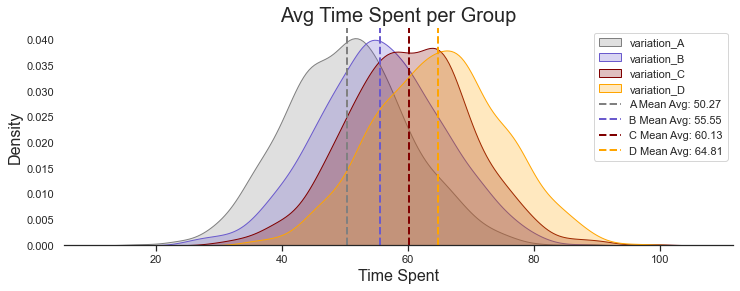

In [ ]:
## Compare distributions of means between the 4 groups
plt.figure(figsize=(12, 4))

sns.kdeplot(anova_data['variation_A'], label='variation_A', fill = True, color = 'grey' )
sns.kdeplot(anova_data['variation_B'], label='variation_B', fill = True, color = 'slateblue')
sns.kdeplot(anova_data['variation_C'], label='variation_C', fill = True, color = 'maroon' )
sns.kdeplot(anova_data['variation_D'], label='variation_D', fill = True, color = 'orange')

mean_group_A = anova_data['variation_A'].mean()
mean_group_B = anova_data['variation_B'].mean()
mean_group_C = anova_data['variation_C'].mean()
mean_group_D = anova_data['variation_D'].mean()

plt.axvline(mean_group_A, color='grey', linestyle='dashed', linewidth=2, label=f'A Mean Avg: {mean_group_A:.2f}')
plt.axvline(mean_group_B, color='slateblue', linestyle='dashed', linewidth=2, label=f'B Mean Avg: {mean_group_B:.2f}')
plt.axvline(mean_group_C, color='maroon', linestyle='dashed', linewidth=2, label=f'C Mean Avg: {mean_group_C:.2f}')
plt.axvline(mean_group_D, color='orange', linestyle='dashed', linewidth=2, label=f'D Mean Avg: {mean_group_D:.2f}')
plt.title('Avg Time Spent per Group', fontsize = 20)
plt.xlabel('Time Spent', fontsize=16)
plt.ylabel('Density', fontsize=16)
plt.tick_params(left=False,bottom=True,labelleft=True,labelbottom=True)
plt.legend()
plt.show()